## IMPORTS

In [164]:
import random
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# import scipy.stats as stats
# from matplotlib.ticker import PercentFormatter
from scipy.stats import zscore

## Análisis de sentimientos

In [165]:
# Inicializar el analizador de sentimiento de NLTK
# sid = SentimentIntensityAnalyzer()

# Función para normalizar el compound score (rango [-1,1]) a un rango de 1 a 10
# def normalize_sentiment(compound_score):
    # Mapear: -1 --> 1 y 1 --> 10
    # return ((compound_score + 1) / 2) * 9 + 1

# Aplicar análisis de sentimiento a cada comentario y normalizarlo
# df['sentiment'] = df['comment'].apply(lambda x: sid.polarity_scores(x)['compound'])
# df['sentiment_normalized'] = df['sentiment'].apply(normalize_sentiment)
# df.head(5)

## Métodos necesarios

In [166]:

# Reemplaza los valores atípicos que pueden generar confusión a la hora de entrenar el modelo ML
def arreglar_dispersion(df, columnas, z_score_umbral):
    for col in columnas:
        # Z-score es mide cuántas desviaciones estándar se encuentra un valor respecto a la media.
        z_scores = np.abs(zscore(df[col], nan_policy='omit'))  # Calcula Z-score
        df.loc[z_scores > z_score_umbral, col] = np.nan  # Sustituye atípicos con NaN


In [167]:
def comprobar_dispersion(df, cols):
    z_scores = df[cols].apply(zscore)

# Contar cuántos valores atípicos hay en cada columna (valores con |Z-score| > 3)
    outlier_counts = (abs(z_scores) > 3).sum()

# Mostrar columnas con valores atípicos
    print(outlier_counts[outlier_counts > 0].sort_values(ascending=False))

In [168]:
def limpiador_nombres(df_a_limpiar):
    # Limpiar nombres de columnas: convertir a minúsculas y reemplazar espacios por '_'
    
    df_a_limpiar.columns = df_a_limpiar.columns.str.lower().str.replace(' ', '_')

    return df_a_limpiar

## Código

In [169]:
# Columnas seleccionas del dataset con la información de los juegos
INFO_JUEGO_COLS = ['id',
                   'primary',
                   'yearpublished',
                   'playingtime',
                   'boardgamecategory', 
                   'maxplayers',
                   'average']

# Columans seleccionadas de las reviews
RATING_COLS = ['user',
               'rating',
               'ID', 
               'comment']

PROBABILIDAD_FALLO = 0.2
TOP_JUEGOS = 1000
UMBRAL_CORRELACION = 0.3
DELIMITADOR_Z_SCORE = 3
EJEMPLO_JUEGO = None

FILTRO_CATEGORIA = {
    "boardgamecategory": None
}
FILTRO_NUMERICO = {
    "playingtime": None,
    "average": {"measure": "above", "threshold": 7}
}


In [170]:
# Semilla aleatoria utilizando el tiempo del sistema
random.seed(int(time.time()))
# Permite transdformar los usuarios a números enteros
label_encoder = LabelEncoder()


# Para mostrar datos de forma gráfica
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [171]:
# Lectura CSV
info_juegos = pd.read_csv("../data/games_detailed_info.csv",
        usecols=INFO_JUEGO_COLS, 
        dtype={'id': 'uint32', 
                'primary': 'string', 
                'yearpublished': 'uint16', 
                'maxplayers': 'uint16',
                'playingtime': 'uint32',
                'average': 'float16'
                })

# Eliminar nulos, duplicados.
info_juegos = info_juegos.dropna()
info_juegos = info_juegos.drop_duplicates()

#  Eliminar espacios en blancos
info_juegos['primary'] = info_juegos['primary'].str.lower()
info_juegos['primary'] = info_juegos['primary'].str.replace(' ', '_')


# Info

# info_juegos.info()
# info_juegos.isnull().values.any()
# info_juegos.isnull().sum().sum()
# info_juegos.head(10)
info_juegos.describe()

C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,id,yearpublished,maxplayers,playingtime,average
count,21348.000000,21348.000000,21348.000000,21348.000000,2.134800e+04
mean,117155.445709,2019.979108,5.706296,91.201143,inf
std,104926.299730,1410.110780,15.146511,538.314958,9.296875e-01
min,1.000000,0.000000,0.000000,0.000000,1.041016e+00
25%,12132.500000,2001.000000,4.000000,25.000000,5.832031e+00
50%,103655.500000,2011.000000,4.000000,45.000000,6.449219e+00
75%,205605.500000,2017.000000,6.000000,90.000000,7.042969e+00
max,350992.000000,65436.000000,999.000000,60000.000000,9.570312e+00


In [172]:
# Reemplazar valores atípicos con NaN
arreglar_dispersion(info_juegos, ['playingtime', 'maxplayers'], DELIMITADOR_Z_SCORE)

# Mostrar info optimizada
info_juegos.describe()

C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,id,yearpublished,maxplayers,playingtime,average
count,21348.000000,21348.000000,21163.000000,21282.000000,2.134800e+04
mean,117155.445709,2019.979108,4.751028,74.275538,inf
std,104926.299730,1410.110780,3.018053,107.306525,9.296875e-01
min,1.000000,0.000000,0.000000,0.000000,1.041016e+00
25%,12132.500000,2001.000000,4.000000,25.000000,5.832031e+00
50%,103655.500000,2011.000000,4.000000,45.000000,6.449219e+00
75%,205605.500000,2017.000000,6.000000,90.000000,7.042969e+00
max,350992.000000,65436.000000,50.000000,1560.000000,9.570312e+00


In [173]:
reviews = pd.read_csv("../data/bgg-26m-reviews.csv", 
                      usecols=RATING_COLS, skiprows=lambda x: x > 0 and random.random() >= PROBABILIDAD_FALLO,
                      dtype={'user': 'string', 
                             'rating': 'float16', 
                             'ID': 'uint32',
                             'comment': 'string'})


In [174]:
reviews = reviews.dropna()
reviews = reviews.drop_duplicates(subset=["user", "ID"], keep="first")

reviews['rating'] = reviews['rating'].astype(np.int8)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843269 entries, 3 to 5238945
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user     843269 non-null  string
 1   rating   843269 non-null  int8  
 2   comment  843269 non-null  string
 3   ID       843269 non-null  uint32
dtypes: int8(1), string(2), uint32(1)
memory usage: 23.3 MB


In [175]:
reviews.head()

,user,rating,comment,ID
3,daredevil,10,This is probably the best game I ever played. ...,13
6,Blaster,10,The All time classic.,13
9,Shooter,10,All time classic super favorite - my first Ger...,13
10,Don Quixote,10,This game single handedly started my board gam...,13
11,krystrandya,10,I am so glad this game exists. Fun. It's for...,13


In [176]:
# Filtra por los registros que coinciden con el id de info_juegos
reviews = reviews[reviews['ID'].isin(info_juegos['id'])]
reviews.head(4)

,user,rating,comment,ID
3,daredevil,10,This is probably the best game I ever played. ...,13
6,Blaster,10,The All time classic.,13
9,Shooter,10,All time classic super favorite - my first Ger...,13
10,Don Quixote,10,This game single handedly started my board gam...,13


In [177]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 794445 entries, 3 to 5238925
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user     794445 non-null  string
 1   rating   794445 non-null  int8  
 2   comment  794445 non-null  string
 3   ID       794445 non-null  uint32
dtypes: int8(1), string(2), uint32(1)
memory usage: 22.0 MB


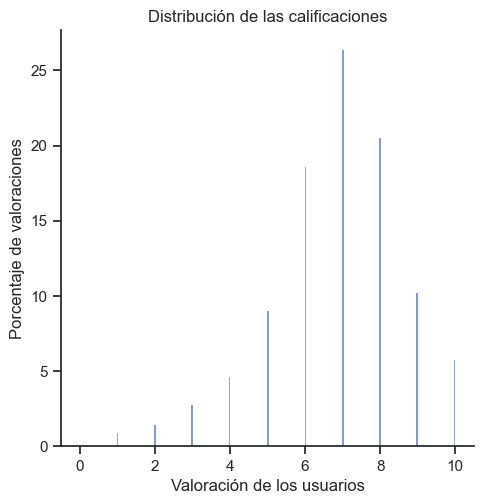

In [178]:
ax = sns.displot(data=reviews, x='rating', stat='percent', fill="blue")
ax.set(xlabel="Valoración de los usuarios",
       ylabel='Porcentaje de valoraciones',
       title='Distribución de las calificaciones')

In [179]:
# Genera una tabla agrupando por id de juego y mostrando el número de usuarios que han valorado el juego y la media total de la valoración.
rated_games = reviews.groupby("ID").agg({"rating": "mean", "user": "count"}).reset_index()
rated_games.sort_values("rating", ascending=False)

,ID,rating,user
19926,309545,10.0,2
11923,144413,10.0,1
16435,227888,10.0,1
16001,218489,10.0,3
6004,17482,10.0,1
...,...,...,...
16390,227010,1.0,1
18823,277565,1.0,2
3894,7269,1.0,1
15474,206274,1.0,3


## Modelo de recomendación

In [180]:
# Ordenado por juego con mayor cantidad de usuarios que han valorado dicho juego
rated_games = rated_games.sort_values(by='user', ascending=False)
rated_games = rated_games.head(TOP_JUEGOS)
rated_games.head()

,ID,rating,user
662,822,7.309588,3734
12,13,7.034548,3705
7566,30549,7.426860,3172
9394,68448,7.511478,2788
4547,9209,7.297716,2583


In [184]:
sample_reviews = reviews[reviews['ID'].isin(rated_games['ID'])]
sample_reviews.head()

,user,rating,comment,ID
3,daredevil,10,This is probably the best game I ever played. ...,13
6,Blaster,10,The All time classic.,13
9,Shooter,10,All time classic super favorite - my first Ger...,13
10,Don Quixote,10,This game single handedly started my board gam...,13
11,krystrandya,10,I am so glad this game exists. Fun. It's for...,13


In [188]:
games_matrix = sample_reviews.pivot_table(index='user',columns='ID',values='rating')
games_matrix.fillna(0)

ID,1,3,5,7,10,11,12,13,15,18,...,325494,328871,329465,329839,331106,336986,341169,342942,345584,346703
user,,,,,,,,,,,,,,,,,,,,,
-Johnny-,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-LucaS-,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-Morphling-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-PEDROPABLO-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-mIDE-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzsoffi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zztap,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zzyzxuk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
if EJEMPLO_JUEGO is None:
    random_game = rated_games.sample(1).to_dict('records')[0]
    game_id = random_game['id']
else:
    game_id = EJEMPLO_JUEGO

In [ ]:
single_game_corr = games_matrix.corrwith(games_matrix[game_id])
single_game_corr = pd.DataFrame(single_game_corr, columns=["correlation"])
single_game_corr = single_game_corr.dropna().sort_values(by="correlation",ascending=False)
recommender_results = single_game_corr.join(info_juegos.set_index("id")).reset_index()
recommender_results.head(3)
# Muestra aquellos juegos que fueron calificados similarmente por otros usuarios y los recomienda al tener
# una puntuación más o menos similar

,id,correlation,primary,yearpublished,minplayers,maxplayers,playingtime,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgamepublisher,usersrated,average,Board Game Rank,numcomments,averageweight
0,164928,1.000000,Orléans,2014,2.0,4.0,90.0,"['Medieval', 'Religious', 'Travel']","['Deck, Bag, and Pool Building', 'Point to Poi...","['Cities: Orléans (France)', 'Country: France'...",['Reiner Stockhausen'],"['dlp games', 'Arclight', 'Arrakis Games', 'Ba...",24610,8.07449,27.0,3691,3.0398
1,102104,0.642864,Star Fluxx,2011,2.0,6.0,40.0,"['Card Game', 'Science Fiction']","['Hand Management', 'Set Collection']","['Digital Implementations: Board Game Arena', ...",['Andrew Looney'],"['Looney Labs', 'Black Monk']",5183,6.34484,2295.0,856,1.4341
2,315767,0.592363,Cartographers Heroes,2021,1.0,NaN,45.0,"['Fantasy', 'Territory Building']","['Bingo', 'Grid Coverage', 'Line Drawing', 'Pa...","['Components: Polyominoes', 'Crowdfunding: Kic...","['Jordy Adan', 'John Brieger']","['Thunderworks Games', 'Gameland 游戏大陆', 'Gen-X...",825,8.00648,1461.0,265,2.1250


In [ ]:
recommender_results = recommender_results[recommender_results['id']!=game_id]

recommender_results = recommender_results[recommender_results['correlation'] >= UMBRAL_CORRELACION]
for filter_type, filter_value in FILTRO_CATEGORIA.items():
    if filter_value is not None:
        recommender_results = recommender_results[recommender_results[filter_type].str.contains(filter_value)]
for filter_type, filter_value in FILTRO_NUMERICO.items():
    if filter_value is not None:
        if filter_value['measure'] == "above":
            recommender_results = recommender_results[recommender_results[filter_type]>=filter_value['threshold']]
        else:
            recommender_results = recommender_results[recommender_results[filter_type]<=filter_value['threshold']]
# Ver el top 5
recommender_results.head()

,id,correlation,primary,yearpublished,minplayers,maxplayers,playingtime,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgamepublisher,usersrated,average,Board Game Rank,numcomments,averageweight
2,315767,0.592363,Cartographers Heroes,2021,1.0,NaN,45.0,"['Fantasy', 'Territory Building']","['Bingo', 'Grid Coverage', 'Line Drawing', 'Pa...","['Components: Polyominoes', 'Crowdfunding: Kic...","['Jordy Adan', 'John Brieger']","['Thunderworks Games', 'Gameland 游戏大陆', 'Gen-X...",825,8.00648,1461.0,265,2.1250
3,328565,0.569493,Caper: Europe,2021,2.0,2.0,35.0,['Card Game'],"['Area Majority / Influence', 'Card Drafting',...","['Continents: Europe', 'Crowdfunding: Kickstar...",['Unai Rubio'],['Keymaster Games'],138,7.92106,5580.0,78,2.3333
4,284378,0.551597,Kanban EV,2020,1.0,4.0,180.0,"['Economic', 'Industry / Manufacturing']","['Action Points', 'Hand Management', 'Variable...","['Crowdfunding: Kickstarter', 'Theme: Automoti...",['Vital Lacerda'],"['Eagle-Gryphon Games', 'Editions Philibert', ...",2953,8.61602,128.0,630,4.3544
5,231581,0.550741,AuZtralia,2018,1.0,4.0,120.0,"['Economic', 'Exploration', 'Fantasy', 'Horror']","['Action Retrieval', 'Cooperative Game', 'Hexa...","['Country: Australia', 'Crowdfunding: Kickstar...",['Martin Wallace'],"['SchilMil Games, Ltd.', 'Arclight', 'Edicione...",3599,7.38666,675.0,847,2.9433
6,255984,0.532926,Sleeping Gods,2021,1.0,4.0,1200.0,"['Adventure', 'Exploration', 'Nautical']","['Cooperative Game', 'Events', 'Hand Managemen...","['Components: Book as Board', 'Components: Map...",['Ryan Laukat'],"['Red Raven Games', 'Banana Games', 'dV Giochi...",2872,8.50843,189.0,941,3.1241


In [ ]:
info_juegos[info_juegos['id']==game_id]

,id,primary,yearpublished,minplayers,maxplayers,playingtime,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgamepublisher,usersrated,average,Board Game Rank,numcomments,averageweight
105,164928,Orléans,2014,2.0,4.0,90.0,"['Medieval', 'Religious', 'Travel']","['Deck, Bag, and Pool Building', 'Point to Poi...","['Cities: Orléans (France)', 'Country: France'...",['Reiner Stockhausen'],"['dlp games', 'Arclight', 'Arrakis Games', 'Ba...",24610,8.07449,27.0,3691,3.0398


In [ ]:
recommender_results.head(1)

,id,correlation,primary,yearpublished,minplayers,maxplayers,playingtime,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgamepublisher,usersrated,average,Board Game Rank,numcomments,averageweight
2,315767,0.592363,Cartographers Heroes,2021,1.0,NaN,45.0,"['Fantasy', 'Territory Building']","['Bingo', 'Grid Coverage', 'Line Drawing', 'Pa...","['Components: Polyominoes', 'Crowdfunding: Kic...","['Jordy Adan', 'John Brieger']","['Thunderworks Games', 'Gameland 游戏大陆', 'Gen-X...",825,8.00648,1461.0,265,2.125


## Modelo ML

In [ ]:
# Debería de calcular el en base al id del juego, la correlación. 
# Volver al bloque donde se encuentra la siguiente variable: 
# 
# single_game_corr
#
# Esa variable almacena la correlación entre un juego y otro, por lo tanto, si 
# el modelo debe tener como parámetros de entra el id del juego y el id del usuario y como resultado la correlación (más o menos)
# 
# INVESTIGAR